In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power

# ---- Synthetic Data Generation ----
def generate_synthetic_data(d, N_train, N_test, sigma=5.0):
    """
    Generate synthetic data for a linear model with Gaussian random noise.
    The user can set 'sigma' to control the scale of the random draws.
    Returns:
        theta_actual: ground-truth parameter in R^d
        X_train     : shape (N_train, d)
        y_train     : shape (N_train,)
        X_test      : shape (N_test, d)
    """
    # Random ground truth
    theta_actual = sigma * np.random.randn(d)

    # Training set
    X_train = sigma * np.random.randn(N_train, d)
    y_train = X_train @ theta_actual + np.random.randn(N_train)

    # Test set
    X_test  = sigma * np.random.randn(N_test, d)

    return theta_actual, X_train, y_train, X_test

# ---- Ridge Regression Estimator ----
def ridge_regression_estimator(X, y, indices, lambda_ridge=1.0):
    """
    Fits a ridge regression model on the subset of points given by 'indices'.
    Returns:
      theta_hat : estimated parameters in R^d
    """
    X_S = X[list(indices), :]
    y_S = y[list(indices)]
    d = X_S.shape[1]
    # We keep the 0.02 factor in place for the ridge matrix, as stated.
    A = X_S.T @ X_S + 0.02 * np.eye(d)
    theta_hat = np.linalg.inv(A) @ (X_S.T @ y_S)
    return theta_hat

def evaluate_loss(X_test, theta_actual, theta_hat):
    """
    Computes the absolute error for each test sample, returns mean and std.

    Returns: (mean_error, std_error)
    """
    errors = np.abs(X_test @ (theta_actual - theta_hat))  # shape (N_test,)
    return np.mean(errors), np.std(errors)

# ---- DPP-based CEIL (Exponentiated Matrix) ----
# def build_dpp_kernel(demo_embeds, test_embed, lambda_dpp=1.0):
#     """
#     Constructs the conditional DPP kernel matrix L' for numerical data
#     such that:
#       log det(L') = sum_{i in S} r[i] + lambda_dpp * log det(L_S).

#     Steps:
#       1) r[i] = dot(demo_embeds[i], test_embed).
#       2) L = demo_embeds @ demo_embeds.T
#       3) L^lambda
#       4) L' = diag(exp(r[i]/2)) @ (L^lambda) @ diag(exp(r[j]/2)).
#     """
#     # 1) Relevance scores
#     r = np.einsum("ij,j->i", demo_embeds, test_embed)  # shape (n,)

#     # 2) Base kernel: L
#     L = demo_embeds @ demo_embeds.T  # shape (n,n)

#     # 3) Raise L to power lambda_dpp
#     if abs(lambda_dpp - int(lambda_dpp)) < 1e-12:
#         L_lambda = np.linalg.matrix_power(L, int(lambda_dpp))
#     else:
#         L_lambda = fractional_matrix_power(L, lambda_dpp)

#     # 4) Diagonal scaling
#     # We clip to avoid overflow, but that's optional:
#     r_clipped = np.clip(r / 2.0, -30, 30)
#     D = np.exp(r_clipped)

#     Lprime = (D[:, None] * L_lambda) * D[None, :]

#     return Lprime

# def dpp_map_inference(Lprime, k_select):
#     """
#     Greedy MAP inference for DPP.
#     Picks items one by one, maximizing the incremental log-det.
#     """
#     n = Lprime.shape[0]
#     selected = []
#     current_logdet = 0.0

#     def submatrix_logdet(indices):
#         if len(indices) == 0:
#             return 0.0
#         subm = Lprime[np.ix_(indices, indices)]
#         sign, val = np.linalg.slogdet(subm)
#         if sign <= 0:
#             return -1e15  # degenerate or negative => huge penalty
#         return val

#     candidates = set(range(n))
#     for _ in range(k_select):
#         best_gain = -1e9
#         best_item = None
#         for i in candidates:
#             new_set = selected + [i]
#             gain = submatrix_logdet(new_set) - current_logdet
#             if gain > best_gain:
#                 best_gain = gain
#                 best_item = i

#         # Fallback if best_item is None => meltdown
#         if best_item is None:
#             if len(candidates) == 0:
#                 break
#             best_item = np.random.choice(list(candidates))
#             best_gain = 0.0

#         selected.append(best_item)
#         candidates.remove(best_item)
#         current_logdet += best_gain

#     return selected

# ---- CEIL Simple (Sir's Method) ----
def ceil_simple_select(demo_embeds, test_embed, k, lambd):
    """
    Implements the 'CEIL Simple' approach:
       x_i = argmax_{x} [ z^T x + lambd * log(1 + x^T V^-1 x) ]

    We'll initialize V_S = 0.02 * I for consistency with your code.
    """
    n, d = demo_embeds.shape
    selected = []
    V_S = 0.02 * np.eye(d)
    candidate_indices = set(range(n))

    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            relevance = test_embed @ x
            denom = 1.0 + x @ invV_S @ x
            score = relevance + lambd * np.log(denom)

            if score > best_val:
                best_val = score
                best_idx = i

        selected.append(best_idx)
        candidate_indices.remove(best_idx)

        # Update V_S
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

# ---- NEW: CEIL Simple (No Log) ----
def ceil_simple_no_log_select(demo_embeds, test_embed, k, lambd):
    """
    Implements the 'CEIL Simple No Log' approach:
       x_i = argmax_{x} [ z^T x + lambd * (1.0 + x^T V^-1 x) ]

    We'll also initialize V_S = 0.02 * I for consistency.
    """
    n, d = demo_embeds.shape
    selected = []
    V_S = 0.02 * np.eye(d)
    candidate_indices = set(range(n))

    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            relevance = test_embed @ x
            denom = 1.0 + x @ invV_S @ x

            # Now it's linear instead of log:
            score = relevance + lambd * denom

            if score > best_val:
                best_val = score
                best_idx = i

        selected.append(best_idx)
        candidate_indices.remove(best_idx)

        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

# ---- Submodular Method (with log) ----
def submodular_diverse_select(demo_embeds, test_embed, k, lambd):
    """
    The selection rule:
       x_i = argmax_{x} (z^T V^-1 x)^2 / [1 + x^T V^-1 x] + lambd * log(1 + x^T V^-1 x).
    We'll keep V_S = 0.02 * I as in your code.
    """
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = 0.02 * np.eye(d)
    candidate_indices = set(range(n))

    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            numerator = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = numerator / denom + lambd * np.log(denom)
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        candidate_indices.remove(best_idx)
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

# ---- Submodular Method (no log) ----
def submodular_diverse_select_no_log(demo_embeds, test_embed, k, lambd):
    """
    Variation that uses a linearized diversity:
       x_i = argmax_{x} (z^T V^-1 x)^2 / [1 + x^T V^-1 x] + lambd * [1 + x^T V^-1 x].
    We'll keep the 'V_S = 0.02 * I' as in your original code.
    """
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = 0.02 * np.eye(d)

    candidate_indices = set(range(n))
    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            numerator = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = numerator / denom + lambd * denom
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        candidate_indices.remove(best_idx)

        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

def experiment(d, N_train, N_test, K, lambda_ridge, lambda_val, sigma=5.0):
    """
    Runs an experiment comparing:
      1) CEIL Actual (DPP + exponentiated matrix)
      2) CEIL Simple (z^T x + lambda log(1 + x^T V^-1 x))
      3) CEIL Simple No Log (z^T x + lambda * (1 + x^T V^-1 x))
      4) Submodular (with log)
      5) Submodular (no log)

    Inputs:
      d            : dimension
      N_train      : # training points
      N_test       : # test points
      K            : subset size
      lambda_ridge : ridge penalty for the regressor
      lambda_val   : the trade-off parameter for CEIL / Submodular
      sigma        : scale factor for data generation
    """
    # Generate data
    theta_actual, X_train, y_train, X_test = generate_synthetic_data(d, N_train, N_test, sigma=sigma)

    # Convert training inputs as embeddings
    demo_embeds = X_train

    # # --- (A) CEIL Actual (DPP approach) ---
    # Lprime = build_dpp_kernel(demo_embeds, X_test[0], lambda_dpp=lambda_val)
    # indices_dpp = dpp_map_inference(Lprime, k_select=K)
    # theta_hat_dpp = ridge_regression_estimator(X_train, y_train, indices_dpp, lambda_ridge)
    # dpp_mean, dpp_std = evaluate_loss(X_test, theta_actual, theta_hat_dpp)

    # --- (B) CEIL Simple ---
    indices_ceil_simple = ceil_simple_select(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_ceil_simple = ridge_regression_estimator(X_train, y_train, indices_ceil_simple, lambda_ridge)
    ceil_simp_mean, ceil_simp_std = evaluate_loss(X_test, theta_actual, theta_hat_ceil_simple)

    # --- (C) CEIL Simple (No Log) ---
    indices_ceil_simple_nolog = ceil_simple_no_log_select(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_ceil_simple_nolog = ridge_regression_estimator(X_train, y_train, indices_ceil_simple_nolog, lambda_ridge)
    ceil_simp_nolog_mean, ceil_simp_nolog_std = evaluate_loss(X_test, theta_actual, theta_hat_ceil_simple_nolog)

    # --- (D) Submodular (with log) ---
    indices_submod = submodular_diverse_select(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_submod = ridge_regression_estimator(X_train, y_train, indices_submod, lambda_ridge)
    submod_log_mean, submod_log_std = evaluate_loss(X_test, theta_actual, theta_hat_submod)

    # --- (E) Submodular (no log) ---
    indices_submod_nolog = submodular_diverse_select_no_log(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_submod_nolog = ridge_regression_estimator(X_train, y_train, indices_submod_nolog, lambda_ridge)
    submod_nolog_mean, submod_nolog_std = evaluate_loss(X_test, theta_actual, theta_hat_submod_nolog)

    return {
        "ceil_simple": {
            "indices": indices_ceil_simple,
            "mean_loss": ceil_simp_mean,
            "std_loss": ceil_simp_std,
        },
        "ceil_simple_nolog": {
            "indices": indices_ceil_simple_nolog,
            "mean_loss": ceil_simp_nolog_mean,
            "std_loss": ceil_simp_nolog_std,
        },
        "submodular_log": {
            "indices": indices_submod,
            "mean_loss": submod_log_mean,
            "std_loss": submod_log_std,
        },
        "submodular_nolog": {
            "indices": indices_submod_nolog,
            "mean_loss": submod_nolog_mean,
            "std_loss": submod_nolog_std,
        }
    }


Varying N: 100%|██████████| 51/51 [3:49:32<00:00, 270.05s/it]  


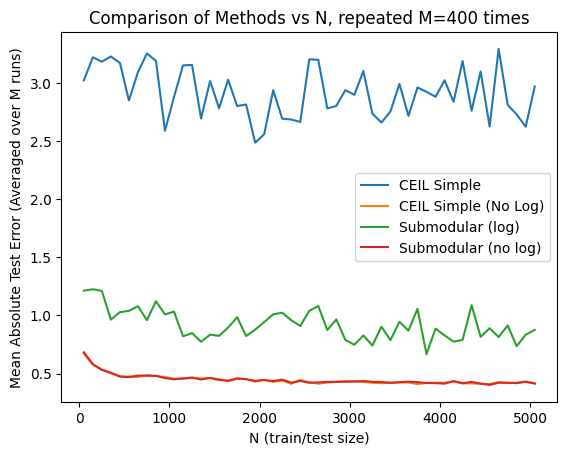

In [4]:
# Cell 3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Decide if we want to show error bars
show_error_bars = False

# Define the range for N
Ns = range(50, 5051, 100)

# Fixed experimental settings
d = 5
K = 5
lambda_ridge = 0.02
lambda_val   = 1.0
sigma        = 5.0

# Number of repeated runs for each N
M = 400

# Lists to store final aggregated results (one per N)
N_list = []
# ceil_dpp_means,      ceil_dpp_stds      = [], []
ceil_simple_means,   ceil_simple_stds   = [], []
ceil_simple_nolog_means, ceil_simple_nolog_stds = [], []
submod_log_means,    submod_log_stds    = [], []
submod_nolog_means,  submod_nolog_stds  = [], []

# Loop over N values with progress bar
for N in tqdm(Ns, desc="Varying N"):
    # For each N, we'll collect M repeated runs
    # all_dpp_means             = []
    all_ceil_simple_means     = []
    all_ceil_simple_nolog_means = []
    all_submod_log_means      = []
    all_submod_nolog_means    = []

    for _ in range(M):
        res = experiment(
            d=d,
            N_train=N,
            N_test=N,
            K=K,
            lambda_ridge=lambda_ridge,
            lambda_val=lambda_val,
            sigma=sigma
        )
        # Each res[...] is a dict with "mean_loss" and "std_loss"
        # all_dpp_means.append(res["ceil_dpp"]["mean_loss"])
        all_ceil_simple_means.append(res["ceil_simple"]["mean_loss"])
        all_ceil_simple_nolog_means.append(res["ceil_simple_nolog"]["mean_loss"])
        all_submod_log_means.append(res["submodular_log"]["mean_loss"])
        all_submod_nolog_means.append(res["submodular_nolog"]["mean_loss"])

    # Now compute mean across M runs (and std across runs) for each method
    # dpp_mean_across_runs = np.mean(all_dpp_means)
    # dpp_std_across_runs  = np.std(all_dpp_means)

    ceil_simple_mean_across_runs = np.mean(all_ceil_simple_means)
    ceil_simple_std_across_runs  = np.std(all_ceil_simple_means)

    ceil_simple_nolog_mean_across_runs = np.mean(all_ceil_simple_nolog_means)
    ceil_simple_nolog_std_across_runs  = np.std(all_ceil_simple_nolog_means)

    submod_log_mean_across_runs = np.mean(all_submod_log_means)
    submod_log_std_across_runs  = np.std(all_submod_log_means)

    submod_nolog_mean_across_runs = np.mean(all_submod_nolog_means)
    submod_nolog_std_across_runs  = np.std(all_submod_nolog_means)

    # Store them in the final arrays
    N_list.append(N)

    # ceil_dpp_means.append(dpp_mean_across_runs)
    # ceil_dpp_stds.append(dpp_std_across_runs)

    ceil_simple_means.append(ceil_simple_mean_across_runs)
    ceil_simple_stds.append(ceil_simple_std_across_runs)

    ceil_simple_nolog_means.append(ceil_simple_nolog_mean_across_runs)
    ceil_simple_nolog_stds.append(ceil_simple_nolog_std_across_runs)

    submod_log_means.append(submod_log_mean_across_runs)
    submod_log_stds.append(submod_log_std_across_runs)

    submod_nolog_means.append(submod_nolog_mean_across_runs)
    submod_nolog_stds.append(submod_nolog_std_across_runs)

# --- Plot results ---
plt.figure()

if show_error_bars:
    # plt.errorbar(N_list, ceil_dpp_means,            yerr=ceil_dpp_stds,            label="CEIL (DPP)")
    plt.errorbar(N_list, ceil_simple_means,         yerr=ceil_simple_stds,         label="CEIL Simple")
    plt.errorb6ar(N_list, ceil_simple_nolog_means,   yerr=ceil_simple_nolog_stds,   label="CEIL Simple (No Log)")
    plt.errorbar(N_list, submod_log_means,          yerr=submod_log_stds,          label="Submodular (log)")
    plt.errorbar(N_list, submod_nolog_means,        yerr=submod_nolog_stds,        label="Submodular (no log)")
else:
    # plt.plot(N_list, ceil_dpp_means,          label="CEIL (DPP)")
    plt.plot(N_list, ceil_simple_means,       label="CEIL Simple")
    plt.plot(N_list, ceil_simple_nolog_means, label="CEIL Simple (No Log)")
    plt.plot(N_list, submod_log_means,        label="Submodular (log)")
    plt.plot(N_list, submod_nolog_means,      label="Submodular (no log)")

plt.xlabel("N (train/test size)")
plt.ylabel("Mean Absolute Test Error (Averaged over M runs)")
plt.title(f"Comparison of Methods vs N, repeated M={M} times")
plt.legend()
plt.show()

Varying subset size k: 100%|██████████| 20/20 [45:29<00:00, 136.48s/it]


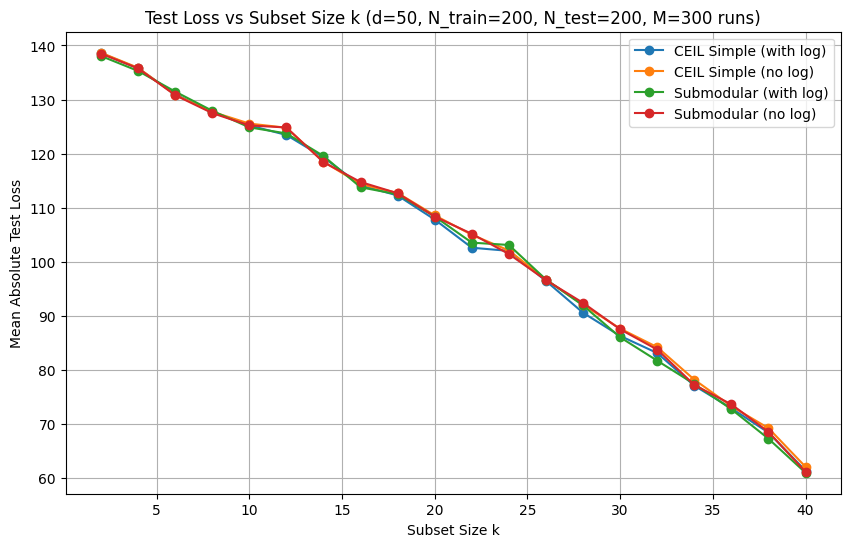

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters fixed for this experiment
d = 50                # Dimension
N_train = 200         # Number of training points
N_test = 200          # Number of test points
lambda_ridge = 1.0    # Ridge regression penalty
lambda_val = 1.0      # Trade-off parameter for demo selection (CEIL / Submodular)
sigma = 5.0           # Scale factor for data generation
M = 300               # Number of repeated runs for each k (adjust as needed)

# Range of subset sizes to evaluate: 2, 4, ..., 20
k_values = list(range(2, 41, 2))

# Dictionaries to store aggregated losses for each method
ceil_simple_losses = []
ceil_simple_nolog_losses = []
submod_log_losses = []
submod_nolog_losses = []

# Loop over each k value and run the experiment M times
for k in tqdm(k_values, desc="Varying subset size k"):
    temp_ceil_simple = []
    temp_ceil_simple_nolog = []
    temp_submod_log = []
    temp_submod_nolog = []
    
    for _ in range(M):
        res = experiment(d=d, N_train=N_train, N_test=N_test, K=k,
                         lambda_ridge=lambda_ridge, lambda_val=lambda_val, sigma=sigma)
        temp_ceil_simple.append(res["ceil_simple"]["mean_loss"])
        temp_ceil_simple_nolog.append(res["ceil_simple_nolog"]["mean_loss"])
        temp_submod_log.append(res["submodular_log"]["mean_loss"])
        temp_submod_nolog.append(res["submodular_nolog"]["mean_loss"])
    
    ceil_simple_losses.append(np.mean(temp_ceil_simple))
    ceil_simple_nolog_losses.append(np.mean(temp_ceil_simple_nolog))
    submod_log_losses.append(np.mean(temp_submod_log))
    submod_nolog_losses.append(np.mean(temp_submod_nolog))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, ceil_simple_losses, marker='o', label="CEIL Simple (with log)")
plt.plot(k_values, ceil_simple_nolog_losses, marker='o', label="CEIL Simple (no log)")
plt.plot(k_values, submod_log_losses, marker='o', label="Submodular (with log)")
plt.plot(k_values, submod_nolog_losses, marker='o', label="Submodular (no log)")
plt.xlabel("Subset Size k")
plt.ylabel("Mean Absolute Test Loss")
plt.title(f"Test Loss vs Subset Size k (d={d}, N_train={N_train}, N_test={N_test}, M={M} runs)")
plt.legend()
plt.grid(True)
plt.show()


Varying N: 100%|██████████| 51/51 [1:54:11<00:00, 134.34s/it]


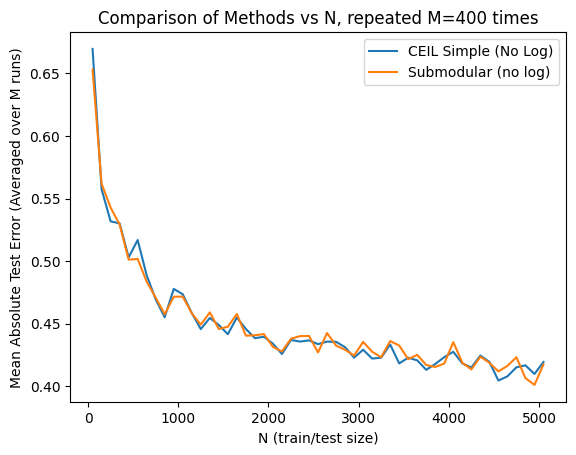

In [2]:
# Cell 3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Decide if we want to show error bars
show_error_bars = False

# Define the range for N
Ns = range(50, 5051, 100)

# Fixed experimental settings
d = 5
K = 5
lambda_ridge = 0.02
lambda_val   = 1.0
sigma        = 5.0

# Number of repeated runs for each N
M = 400

# Lists to store final aggregated results (one per N)
N_list = []
# ceil_dpp_means,      ceil_dpp_stds      = [], []
ceil_simple_means,   ceil_simple_stds   = [], []
ceil_simple_nolog_means, ceil_simple_nolog_stds = [], []
submod_log_means,    submod_log_stds    = [], []
submod_nolog_means,  submod_nolog_stds  = [], []

# Loop over N values with progress bar
for N in tqdm(Ns, desc="Varying N"):
    # For each N, we'll collect M repeated runs
    # all_dpp_means             = []
    all_ceil_simple_means     = []
    all_ceil_simple_nolog_means = []
    all_submod_log_means      = []
    all_submod_nolog_means    = []

    for _ in range(M):
        res = experiment(
            d=d,
            N_train=N,
            N_test=N,
            K=K,
            lambda_ridge=lambda_ridge,
            lambda_val=lambda_val,
            sigma=sigma
        )
        # Each res[...] is a dict with "mean_loss" and "std_loss"
        # all_dpp_means.append(res["ceil_dpp"]["mean_loss"])
        all_ceil_simple_means.append(res["ceil_simple"]["mean_loss"])
        all_ceil_simple_nolog_means.append(res["ceil_simple_nolog"]["mean_loss"])
        all_submod_log_means.append(res["submodular_log"]["mean_loss"])
        all_submod_nolog_means.append(res["submodular_nolog"]["mean_loss"])

    # Now compute mean across M runs (and std across runs) for each method
    # dpp_mean_across_runs = np.mean(all_dpp_means)
    # dpp_std_across_runs  = np.std(all_dpp_means)

    ceil_simple_mean_across_runs = np.mean(all_ceil_simple_means)
    ceil_simple_std_across_runs  = np.std(all_ceil_simple_means)

    ceil_simple_nolog_mean_across_runs = np.mean(all_ceil_simple_nolog_means)
    ceil_simple_nolog_std_across_runs  = np.std(all_ceil_simple_nolog_means)

    submod_log_mean_across_runs = np.mean(all_submod_log_means)
    submod_log_std_across_runs  = np.std(all_submod_log_means)

    submod_nolog_mean_across_runs = np.mean(all_submod_nolog_means)
    submod_nolog_std_across_runs  = np.std(all_submod_nolog_means)

    # Store them in the final arrays
    N_list.append(N)

    # ceil_dpp_means.append(dpp_mean_across_runs)
    # ceil_dpp_stds.append(dpp_std_across_runs)

    ceil_simple_means.append(ceil_simple_mean_across_runs)
    ceil_simple_stds.append(ceil_simple_std_across_runs)

    ceil_simple_nolog_means.append(ceil_simple_nolog_mean_across_runs)
    ceil_simple_nolog_stds.append(ceil_simple_nolog_std_across_runs)

    submod_log_means.append(submod_log_mean_across_runs)
    submod_log_stds.append(submod_log_std_across_runs)

    submod_nolog_means.append(submod_nolog_mean_across_runs)
    submod_nolog_stds.append(submod_nolog_std_across_runs)

# --- Plot results ---
plt.figure()

if show_error_bars:
    # plt.errorbar(N_list, ceil_dpp_means,            yerr=ceil_dpp_stds,            label="CEIL (DPP)")
    plt.errorbar(N_list, ceil_simple_means,         yerr=ceil_simple_stds,         label="CEIL Simple")
    plt.errorbar(N_list, ceil_simple_nolog_means,   yerr=ceil_simple_nolog_stds,   label="CEIL Simple (No Log)")
    plt.errorbar(N_list, submod_log_means,          yerr=submod_log_stds,          label="Submodular (log)")
    plt.errorbar(N_list, submod_nolog_means,        yerr=submod_nolog_stds,        label="Submodular (no log)")
else:
    # plt.plot(N_list, ceil_dpp_means,          label="CEIL (DPP)")
    # plt.plot(N_list, ceil_simple_means,       label="CEIL Simple")
    plt.plot(N_list, ceil_simple_nolog_means, label="CEIL Simple (No Log)")
    # plt.plot(N_list, submod_log_means,        label="Submodular (log)")
    plt.plot(N_list, submod_nolog_means,      label="Submodular (no log)")

plt.xlabel("N (train/test size)")
plt.ylabel("Mean Absolute Test Error (Averaged over M runs)")
plt.title(f"Comparison of Methods vs N, repeated M={M} times")
plt.legend()
plt.show()

Varying subset size k: 100%|██████████| 20/20 [2:39:32<00:00, 478.60s/it] 


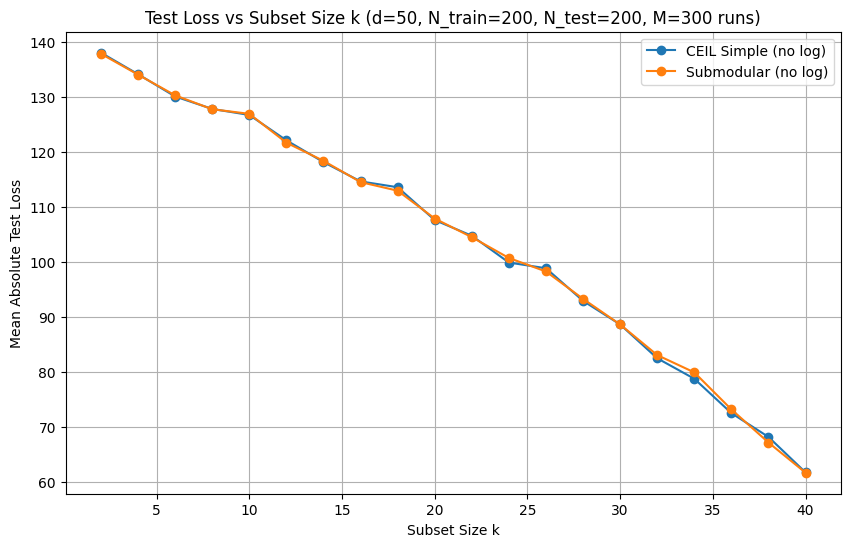

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters fixed for this experiment
d = 50                # Dimension
N_train = 200         # Number of training points
N_test = 200          # Number of test points
lambda_ridge = 1.0    # Ridge regression penalty
lambda_val = 1.0      # Trade-off parameter for demo selection (CEIL / Submodular)
sigma = 5.0           # Scale factor for data generation
M = 300               # Number of repeated runs for each k (adjust as needed)

# Range of subset sizes to evaluate: 2, 4, ..., 20
k_values = list(range(2, 41, 2))

# Dictionaries to store aggregated losses for each method
ceil_simple_losses = []
ceil_simple_nolog_losses = []
submod_log_losses = []
submod_nolog_losses = []

# Loop over each k value and run the experiment M times
for k in tqdm(k_values, desc="Varying subset size k"):
    temp_ceil_simple = []
    temp_ceil_simple_nolog = []
    temp_submod_log = []
    temp_submod_nolog = []
    
    for _ in range(M):
        res = experiment(d=d, N_train=N_train, N_test=N_test, K=k,
                         lambda_ridge=lambda_ridge, lambda_val=lambda_val, sigma=sigma)
        temp_ceil_simple.append(res["ceil_simple"]["mean_loss"])
        temp_ceil_simple_nolog.append(res["ceil_simple_nolog"]["mean_loss"])
        temp_submod_log.append(res["submodular_log"]["mean_loss"])
        temp_submod_nolog.append(res["submodular_nolog"]["mean_loss"])
    
    # ceil_simple_losses.append(np.mean(temp_ceil_simple))
    ceil_simple_nolog_losses.append(np.mean(temp_ceil_simple_nolog))
    # submod_log_losses.append(np.mean(temp_submod_log))
    submod_nolog_losses.append(np.mean(temp_submod_nolog))

# Plot the results
plt.figure(figsize=(10, 6))
# plt.plot(k_values, ceil_simple_losses, marker='o', label="CEIL Simple (with log)")
plt.plot(k_values, ceil_simple_nolog_losses, marker='o', label="CEIL Simple (no log)")
# plt.plot(k_values, submod_log_losses, marker='o', label="Submodular (with log)")
plt.plot(k_values, submod_nolog_losses, marker='o', label="Submodular (no log)")
plt.xlabel("Subset Size k")
plt.ylabel("Mean Absolute Test Loss")
plt.title(f"Test Loss vs Subset Size k (d={d}, N_train={N_train}, N_test={N_test}, M={M} runs)")
plt.legend()
plt.grid(True)
plt.show()